In [3]:
import pandas as pd
import sktime as skt
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from utilities import *

# Variables

In [4]:
# Change this
predicted_col = "day_close"
start_halving = 0
train_percentage = 95
add_regressors_to_prophet = False
shift_length = 3 # Only affects ML models
save_prediction_prophet = True # Starts predicting t=len(training_set)

In [5]:
# No need to change this
assert shift_length >= 0
assert 4 >= start_halving >=0

# Preprocessing

In [6]:
df = load_data()
df.head(10)

,Time,active-addresses-btc-24h,block-height-btc-24h,block-interval-mean-btc-24h,block-interval-median-btc-24h,block-size-mean-btc-24h,block-size-total-btc-24h,blocks-mined-btc-24h,circulating-supply-btc-24h,difficulty-btc-24h,...,transfer-volume-median-btc-24h,transfer-volume-total-btc-24h,utx-os-created-btc-24h,utx-os-spent-btc-24h,utxo-value-created-mean-btc-24h,utxo-value-created-median-btc-24h,utxo-value-created-total-btc-24h,utxo-value-spent-mean-btc-24h,utxo-value-spent-median-btc-24h,utxo-value-spent-total-btc-24h
0,2010-08-17 00:00:00+00:00,365.0,74916.0,659.201550,410.0,675.527132,87143.0,129.0,3745850.0,2.198051e+12,...,50.0,49995.99,419.0,292.0,134.715967,50.0,56445.99,171.219144,50.00,49995.99
1,2010-08-18 00:00:00+00:00,595.0,75049.0,661.496241,455.0,2005.503759,266732.0,133.0,3752500.0,2.198051e+12,...,50.0,37386.94,527.0,1302.0,83.564516,49.0,44038.50,28.716206,0.01,37388.50
2,2010-08-19 00:00:00+00:00,336.0,75184.0,635.518519,429.0,623.651852,84193.0,135.0,3759250.0,2.198051e+12,...,50.0,20402.10,415.0,271.0,65.426747,50.0,27152.10,75.284502,50.00,20402.10
3,2010-08-20 00:00:00+00:00,480.0,75377.0,447.398964,288.0,595.834197,114996.0,193.0,3768900.0,2.198051e+12,...,50.0,29578.41,538.0,388.0,72.915260,50.0,39228.41,76.233015,50.00,29578.41
4,2010-08-21 00:00:00+00:00,365.0,75550.0,501.942197,356.0,539.421965,93320.0,173.0,3777550.0,2.198051e+12,...,50.0,38678.31,437.0,286.0,108.302769,50.0,47328.31,135.238846,50.00,38678.31
5,2010-08-22 00:00:00+00:00,387.0,75762.0,408.674528,287.0,472.556604,100182.0,212.0,3788150.0,2.198051e+12,...,50.0,20418.19,432.0,322.0,71.801366,50.0,31018.19,63.410528,50.00,20418.19
6,2010-08-23 00:00:00+00:00,453.0,75975.0,404.239437,265.0,488.107981,103967.0,213.0,3798800.0,2.198051e+12,...,50.0,17776.11,445.0,338.0,63.878899,50.0,28426.11,52.592041,50.00,17776.11
7,2010-08-24 00:00:00+00:00,448.0,76190.0,402.967442,298.0,836.125581,179767.0,215.0,3809550.0,2.198051e+12,...,50.0,21093.11,465.0,753.0,68.481527,50.0,31843.91,28.013161,0.01,21093.91
8,2010-08-25 00:00:00+00:00,311.0,76406.0,398.833333,254.0,415.458333,89739.0,216.0,3820350.0,2.198051e+12,...,50.0,15911.10,428.0,230.0,62.409112,50.0,26711.10,69.178696,50.00,15911.10
9,2010-08-26 00:00:00+00:00,455.0,76616.0,446.733333,274.0,562.547619,118135.0,210.0,3830850.0,2.677427e+12,...,4.9,14247.79,435.0,404.0,56.891471,50.0,24747.79,35.266807,5.00,14247.79


In [7]:
df = preprocess_df(df, start_halving=start_halving)

In [8]:
df.columns

Index(['Time', 'active-addresses-btc-24h', 'block-height-btc-24h',
       'block-interval-mean-btc-24h', 'block-interval-median-btc-24h',
       'block-size-mean-btc-24h', 'block-size-total-btc-24h',
       'blocks-mined-btc-24h', 'circulating-supply-btc-24h',
       'difficulty-btc-24h', 'ma128', 'ma14', 'ma200', 'ma25', 'ma40', 'ma60',
       'ma9', 'ma90', 'fees-mean-btc-24h', 'fees-median-btc-24h',
       'fees-total-btc-24h', 'hash-rate-btc-24h',
       'investor-capitalization-btc-24h', 'market-cap-btc-24h',
       'new-addresses-btc-24h', 'price-drawdown-from-ath-btc-24h', 'day_close',
       'day_high', 'day_low', 'day_open',
       'realized-profits-to-value-rpv-ratio-btc-24h',
       'receiving-addresses-btc-24h', 'seller-exhaustion-constant-btc-24h',
       'sending-addresses-btc-24h', 'sopr-btc-24h', 'o.daysTillHalving',
       'o.ratio', 'supply-last-active-1-years-ago-btc-24h',
       'total-addresses-btc-24h', 'transaction-count-btc-24h',
       'transaction-rate-btc-24h

# Analysis

In [9]:
# This can provide lots of functions related to rolling averages etc.
ewm = df.ewm(span=7)
ewm.mean()["day_close"]

0           0.070000
1           0.068857
2           0.067924
3           0.067038
4           0.066829
            ...     
4092    61269.470252
4093    61293.852660
4094    61234.946061
4095    61720.352492
4096    62040.044970
Name: day_close, Length: 4097, dtype: float64

# Prediction

# Thetaforecaster
### uses simple exponential smoothing
![Formula](https://i.imgur.com/5mTIBwo.png)

### More here: https://www.youtube.com/watch?v=k_HN0wOKDd0
### Documentation: https://www.sktime.org/en/v0.4.2/modules/auto_generated/sktime.forecasting.theta.ThetaForecaster.html

In [10]:
if train_percentage == 1: # Testing testing
    forecaster = ThetaForecaster()
    forecaster.fit(df[predicted_col])
else:
    y_train, y_test = temporal_train_test_split(df[predicted_col], train_size=train_percentage)
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    forecaster = ThetaForecaster()
    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh)
    mean_absolute_scaled_error(y_test, y_pred, y_train=y_train)
    print(f"""
        Mean Absolute Scaled Error: {mean_absolute_scaled_error(y_test, y_pred, y_train=y_train)}\n
        Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}\n
        Mean Squared Error: {mean_squared_error(y_test, y_pred)}
    """)


        Mean Absolute Scaled Error: 746086.3220276335

        Mean Absolute Error: 6422.168192420288

        Mean Squared Error: 197666272.43885997
    


# Prophet

In [11]:
addtional_variables = [] if not add_regressors_to_prophet else list(filter(lambda x: x not in ("Time", predicted_col), df.columns)) 
pf_df = preprocess_for_prophet(df, extra_columns=addtional_variables)

if shift_length:
    shifted_df = pf_df[-shift_length:][addtional_variables] # Contains values dropped during shifting
    pf_df[addtional_variables] = pf_df[addtional_variables].shift(shift_length)
    pf_df = pf_df.dropna()

if train_percentage == 1:
    pf_train = pf_df
else:
    pf_train, pf_test = train_test_split(pf_df, train_size=train_percentage, shuffle=False)

pf = Prophet()
for variable in addtional_variables:
    pf.add_regressor(variable)

In [12]:
pf.fit(pf_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat  yhat_lower  yhat_upper
0    2010-11-20   0.304776    0.272700    0.334369
1    2010-11-21   0.305025    0.271872    0.334483
2    2010-11-22   0.300905    0.268619    0.330777
3    2010-11-23   0.299833    0.267986    0.330845
4    2010-11-24   0.309605    0.277074    0.338155
...         ...        ...         ...         ...
3997 2021-10-30  20.962610   -6.447412   45.866371
3998 2021-10-31  20.962859   -6.456925   45.906604
3999 2021-11-01  20.958739   -6.461164   45.898653
4000 2021-11-02  20.957667   -6.472930   45.960114
4001 2021-11-03  20.967438   -6.464405   45.960356

[4002 rows x 4 columns]

        Mean Absolute Scaled Error: 745154.9008456568

        Mean Absolute Error: 6414.150697243079

        Mean Squared Error: 197486823.32746074
    


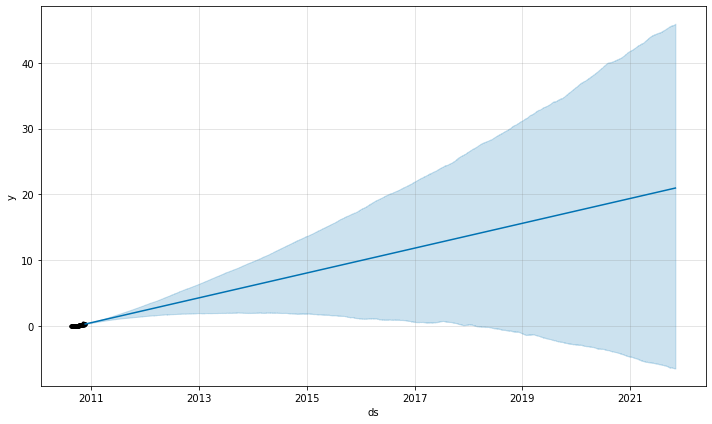

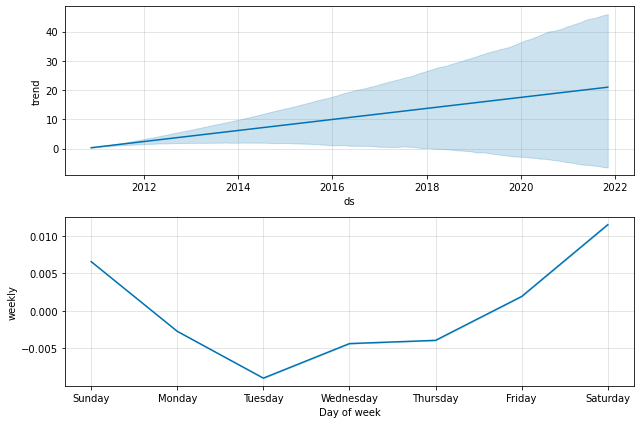

In [13]:
if train_percentage != 1:
    forecast = pf.predict(pf_test)
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
    pf.plot(forecast)
    pf.plot_components(forecast)
    print(f"""
        Mean Absolute Scaled Error: {mean_absolute_scaled_error(pf_test["y"], forecast["yhat"], y_train=pf_train["y"])}\n
        Mean Absolute Error: {mean_absolute_error(pf_test["y"], forecast["yhat"])}\n
        Mean Squared Error: {mean_squared_error(pf_test["y"], forecast["yhat"])}
    """)

In [14]:
if shift_length:
    shifted_df["ds"] = pf.make_future_dataframe(shift_length, include_history=False)["ds"].values
    prediction_df = pf.predict(shifted_df)
    print(prediction_df["yhat"])
    if save_prediction_prophet or True:
        prediction_df[["ds", "yhat", "yhat_lower", "yhat_upper", "trend", "trend_lower", "trend_upper"]].to_csv(\
            f"../data/results/prophet/predicted={predicted_col}_shift={shift_length}_start={prediction_df.iloc[0]['ds'].date()}_regressors={add_regressors_to_prophet}.csv", index=False)

0    0.304776
1    0.305025
2    0.300905
Name: yhat, dtype: float64
